## Movie Revenue Prediction

### Objective: Merge Feature Engineering Dataframe with movies_df to create movies_ml

In [1]:
%load_ext watermark
%watermark -a "Emily Schoof" -d -t -v -p numpy,pandas,matplotlib,sklearn,nltk

Emily Schoof 2019-08-22 12:38:22 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2
matplotlib 3.0.3
sklearn 0.20.3
nltk 3.4


In [2]:
# Load the dataset
%store -r movie_revenue_ml
movie_revenue_ml.shape

(4641, 33)

In [3]:
movie_revenue_ml = movie_revenue_ml.drop(columns='release_date')
movie_revenue_ml.head(2)

,title,revenue,keywords,original_language,production_companies,production_countries,runtime,spoken_languages,release_day_of_week,release_month,...,horror,movie,music,mystery,romance,science,thriller,tv,war,western
0,6,2.787965e+09,"[culture clash, future, space war, space colon...",en,Ingenious Film Partners Twentieth Century Fox ...,US United States America GB United Kingdom,162.0,English Espa,Thursday,12,...,0,0,0,0,0,1,0,0,0,0
1,7,1.845034e+09,"[shipwreck, iceberg, ship, panic, titanic, oce...",en,Paramount Pictures Twentieth Century Fox Film ...,US United States America,194.0,English Fran Deutsch Italiano,Tuesday,11,...,0,0,0,0,1,0,1,0,0,0


## Create a Step-by-Step Pipeline

### Define Target (Movie Revenue *movie_df_unnested['revenue']*) and Feature Variables

In [4]:
# Import relevent modules
from sklearn.model_selection import train_test_split

In [5]:
# Set up the target variable
y_target = movie_revenue_ml['revenue'].values
print('Target: ', y_target.shape)

# Set the feature variables
X_features = movie_revenue_ml.drop(columns=['revenue'], axis = 1)
feature_list = X_features.columns
print('Features: ', X_features.shape)

Target:  (4641,)
Features:  (4641, 31)


### Preprocessing Data

In [6]:
# Import relevant modules
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
movie_revenue_ml.dtypes

title                     int64
revenue                 float64
keywords                 object
original_language        object
production_companies     object
production_countries     object
runtime                 float64
spoken_languages         object
release_day_of_week      object
release_month             int64
action                    int64
adventure                 int64
animation                 int64
comedy                    int64
crime                     int64
documentary               int64
drama                     int64
family                    int64
fantasy                   int64
fiction                   int64
foreign                   int64
history                   int64
horror                    int64
movie                     int64
music                     int64
mystery                   int64
romance                   int64
science                   int64
thriller                  int64
tv                        int64
war                       int64
western 

**Text Columns**

In [8]:
def combine_text_columns(df):
    """ Convert All Values in a Column Into One Vector """
    
    # Replace nulls with empty spaces
    df.fillna('', inplace=True)
    
          # Join all columns into unique vectors
    return df.apply(lambda col: ' '.join(col), axis=1)

In [9]:
text_columns = ['production_companies',
                'production_countries', 'spoken_languages', 'release_day_of_week']

token_alphanumeric = '[A-Za-z0-9]+(?=\\s+)'

X_feature_text = X_features[text_columns]

X_feature_text_vector = combine_text_columns(X_feature_text)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [10]:
# Create a vectorizer instance
hvectorizer = CountVectorizer(binary=False, token_pattern=token_alphanumeric)

# build the vocabulary and convert text to a bag of words
X_features_text_transformed = hvectorizer.fit_transform(X_feature_text_vector)

In [11]:
X_features_text_transformed.shape

(4641, 4956)

**Numerical Values**

In [12]:
numberic_columns = ['runtime', 'release_month']

X_feature_numberic = X_features[numberic_columns]

In [13]:
X_feature_numberic.shape

(4641, 2)

**Combine Processed Text and Numerical Features**

In [14]:
# Import Necessary Modules
import numpy as np
from scipy.sparse import hstack

In [15]:
X_features_processed = hstack((X_features_text_transformed, np.array(X_feature_numberic))).toarray()

In [16]:
X_features_processed.shape

(4641, 4958)

*Observations*: 4958 columns is a high dimensional dataset. Since purley running any model on this dataset would be time-intensive, a dimensionality reduction method needs to be applied. Singular Value Decomposition (SVD) is popular in the field of natural language processing to achieve a representation of the gigantic while sparse word frequency matrices.

### Apply SVD to Features

In [17]:
# Import relevant modules
from sklearn.decomposition import TruncatedSVD

In [18]:
# Create an SVD instance with ~1/3 n_components
tsvd = TruncatedSVD(n_components=1200, random_state=42)

# Fit SVD to X_features_processed
X_features_svd = tsvd.fit_transform(X_features_processed)

In [19]:
# Sum explained variances to assess if the reduced features capture the variability in the data
tsvd_var_ratios = tsvd.explained_variance_ratio_.sum()
tsvd_var_ratios

0.9990746010962359

In [20]:
X_features_svd.shape

(4641, 1200)

### Standard Scale Data

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
# Standarize features
scaler = StandardScaler()

# Fit to data
X_features_scaled = scaler.fit_transform(X_features_svd)

In [23]:
X_features_scaled.shape

(4641, 1200)

### Split Data

In [24]:
# Create train and test data sets -> Arbitrary Random State of 42 Set with test/train size of 30/70 (>25% of data)
X_train, X_test, y_train, y_test = train_test_split(X_features_svd, y_target, test_size=0.3, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

3248 1393 3248 1393


((3248, 1200), (1393, 1200), (3248,), (1393,))

## Model Selection: Ridge Regression
- Shrink the coefficients and it helps to reduce the model complexity and multi-collinearity
- Higher the alpha value, more restriction on the coefficients
- MSE is a measure of the quality of the estimator while MAE is a measure that returns the weighted average of all output errors

**Determine Best Alpha for Model**

In [25]:
# Import necessary modules
from sklearn.linear_model import RidgeCV

In [26]:
# Create ridge regression with five possible alpha values
potential_alphas = 10**np.linspace(10,-2,100)*0.5

# Create ridgecv instance with potential alphas and 10 cross validations
ridge_cv = RidgeCV(cv=5, alphas=potential_alphas, scoring='neg_mean_absolute_error', normalize=True)

**WARNING: SLOW-RUNNING CELL**

In [27]:
# Fit to entire data
ridge_cv = ridge_cv.fit(X_features_scaled, y_target)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
# Assess coefficients
ridge_cv.coef_ # zip together with features .list(zip(ridge_cv))

array([10486038.62415064,  1772030.86222349, -5291264.5738214 , ...,
         293416.88895229,   283604.67984306,  -154590.28980803])

In [29]:
# View best alpha for the ridge model
optimal_alpha = round(ridge_cv.alpha_, 4)
optimal_alpha

1.7556

**Create a Ridge Regression Model**

In [30]:
# Import relevant modules
from sklearn.linear_model import Ridge

In [31]:
# Create a rigde instance with optimal alpha
ridge_reg = Ridge(alpha=optimal_alpha, normalize=True)

# Fit to training data
ridge_reg.fit(X_train, y_train)

Ridge(alpha=1.7556, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

#### Assess Model Accuracy

In [32]:
# Import metrics modules
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.gofplots import qqplot

*Observations*: Using the standard-scaled features with reduced dimensionality, the large alpha appears to predict movie revenue with relatively high accuracy for both the training and testing datasets.

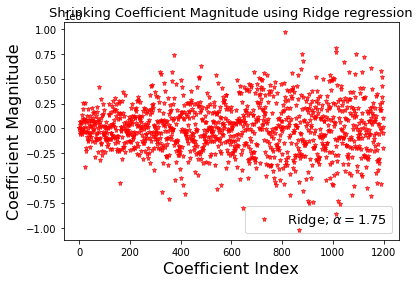

In [33]:
plt.plot(ridge_reg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 1.75$',zorder=7) # zorder for ordering the markers
plt.title('Shrinking Coefficient Magnitude using Ridge regression',fontsize=13)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [34]:
# Evaluate Model Performance
ridge_y_pred = ridge_reg.predict(X_test)
performance_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': ridge_y_pred.flatten()})
performance_df.head()

,Actual,Predicted
0,2.550002e+08,9.149105e+07
1,3.808578e+07,1.134151e+08
2,1.012778e+08,8.098702e+07
3,3.735521e+08,1.620301e+08
4,1.244940e+05,7.468792e+07


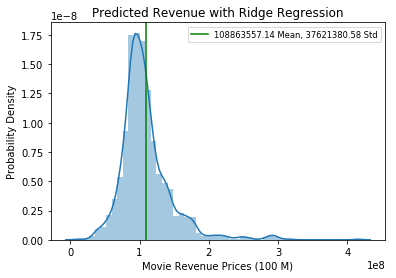

In [35]:
# Plot model
ridge_pred_mean = np.mean(ridge_y_pred)
ridge_pred_std = np.std(ridge_y_pred)
sns.distplot(ridge_y_pred)
plt.axvline(x=ridge_pred_mean, color='green', label='{0:2.2f} Mean, {1:2.2f} Std'.format(ridge_pred_mean, ridge_pred_std))
plt.legend(fontsize = 'small', loc='upper right')
plt.title("Predicted Revenue with Ridge Regression")
plt.xlabel("Movie Revenue Prices (100 M)")
plt.ylabel("Probability Density")
plt.show()

In [36]:
# Calculate the mean squared errors -TRAIN-
rr_mean_squ_error = mean_squared_error(y_train, ridge_reg.predict(X_train))
rr_mean_abs_error = mean_absolute_error(y_train, ridge_reg.predict(X_train))
print("Ridge Regression training mse=$", round(rr_mean_squ_error, 2)," & rmse=$", round(sqrt(rr_mean_squ_error),2))
print("Ridge Regression training mae=$", round(rr_mean_abs_error, 2))

Ridge Regression training mse=$ 1.5337459796725336e+16  & rmse=$ 123844498.45
Ridge Regression training mae=$ 67173606.03


In [37]:
# Calculate the mean squared errors -TEST-
rr_test_mean_squ_error = mean_squared_error(y_test, ridge_reg.predict(X_test))
rr_test_mean_abs_error = mean_absolute_error(y_test, ridge_reg.predict(X_test))
print("Ridge Regression testing mse=$", round(rr_test_mean_squ_error, 2)," & rmse=$", round(sqrt(rr_test_mean_squ_error),2))
print("Ridge Regression testing mae=$", round(rr_mean_abs_error, 2))

Ridge Regression testing mse=$ 1.838829359003865e+16  & rmse=$ 135603442.4
Ridge Regression testing mae=$ 67173606.03


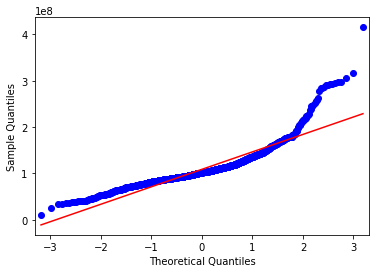

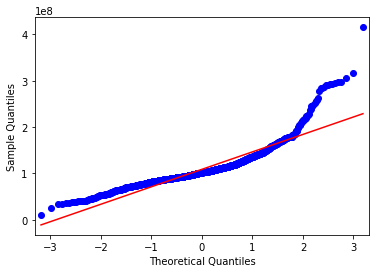

In [38]:
qqplot(ridge_y_pred, line='s')

**Conclusion**: This model appears to predict unseen data within a **mean absolute error of ~67 million** with decreased accuracy as the tendancy to over-estimate large values that exceed quantile 2. Since the mean absolute error of the training set is also approximately **mean absolute error of ~67 million**, the model did not overfit on the training data.

### Create a Pipeline

In [149]:
# Import necessary modules
from sklearn.pipeline import Pipeline

In [182]:
steps = [('tsvd', TruncatedSVD(n_components=2498, random_state=42)),
         ('scaler', StandardScaler()), 
         ('rr', Ridge(alpha=500))]

revenue_prediction_pipeline = Pipeline(steps) # define the pipeline object.

In [28]:
revenue_prediction_pipeline = Pipeline([
    
        # Streamline Preprocessing 
        ('union', FeatureUnion(
            
            transformer_list = [
                
                # Pipeline and Functions for Numerical Data
                ('numeric_features', Pipeline([
                    ('selector', select_numeric_data),
                    ('imputer', SimpleImputer())
                    ]
                )),
                
                # Pipeline and Functions for Categorical Data
                ('text_features', Pipeline([
                    ('selector',  select_text_data),
                    # Reduce potential dimensionality from CounterVectorizer by creating hashes instead
                    ('vectorizer', CountVectorizer()),
                    # chi-squared test to select the K features
                    ('dim_red', SelectKBest())
                    ]
                ))
             ]
        )),
        #('scale', StandardScaler()),
        ('rfr', RandomForestRegressor())
    ])

In [29]:
parameters = [
    {'rfr' : [ 
        RandomForestRegressor(
            random_state=42, max_depth=5, n_estimators=100)
    ]},
    {'vectorizer' : [ 
        CountVectorizer(
            stop_words='english')
    ]},
    {'dim_red': [SelectKBest(chi2, k=chi_k)]}
]

In [ ]:
non_negative=True, norm=None, binary=False, ngram_range=(1, 2)

In [30]:
# Create the grid search object
pipeline_cv = GridSearchCV(estimator=revenue_prediction_pipeline,
                  param_grid=parameters,
                  refit=True,
                  cv=5, 
                  n_jobs=-1,
                  verbose=0,
                  scoring='neg_mean_absolute_error')

In [ ]:
# Seed the random number generator
np.random.seed(42)

# Fit pipeline_cv to the training data
grid_result = pipeline_cv.fit(X_train, y_train)